<center><h2><b>ClubHouse Data - Plotly EDA</b><h2></center>
<center><img src ="https://techweez.com/wp-content/uploads/2021/01/clubhouse.png" width="300"></center>

<center><b>** updated with networkx plots **</b></center>

<center><b>Clubhouse (joinclubhouse.com)</b> is a social networking app that lets people gather in audio chat rooms to discuss various topics. Currently only the iOS version is available and membership is by invitation only.</center>

This dataset contains **1300515** user profiles in clubhouse. Each row shows a user's profile information, including:

>1. **user_id**
>2. **name**
>3. **photo_url**
>4. **username**
>5. **twitter**
>6. **Instagram**
>7. **num_followers**
>8. **num_following**
>9. **time_created**
> 10. **invitedbyuser_profile**

In this notebook I have clustered users into **3 clusters** based on number of followers for ease of analysis:
> 1. **More than 1 Million Followers - Cluster 1**
> 2. **Between 1 Million and 100k Followers - Cluster 2**
> 3. **Between 100k and 10k Followers - Cluster 3**

I tried to investigae the following questions:
> 1. **Number of new users created each day.**
> 2. **Top 20 Users who have invited the most other users.**
> 3. Profile Completeness of users based on cluster:
>    * **Do users with most followers have profile pictures?**
>    * **Do users with most followers have other social media accounts like twitter and instagram?**
> 4. **Network Diagram for top two users who invited highest number of other users.**
>5. **Network Diagram of a randomly selected user.**

In [1]:
import pandas as pd
import sqlite3
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
con = sqlite3.connect("../input/clubhouse-dataset/Clubhouse_Dataset_v1.db")
users_df = pd.read_sql_query("SELECT * from user", con)
users_df = users_df.replace(to_replace ='null',value ='')

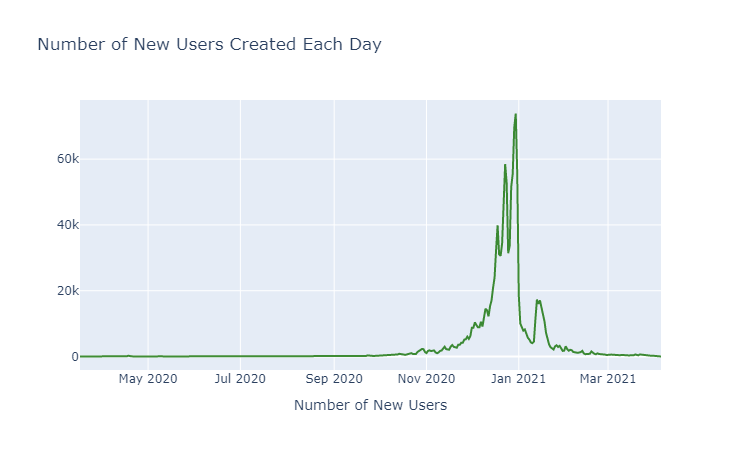

In [3]:
users_df['time_created'] = pd.to_datetime(users_df['time_created']).apply(lambda x: x.date())
date_creation_df = pd.DataFrame(users_df.groupby('time_created')['user_id'].apply(list))
for i in range(date_creation_df.shape[0]):
    date_creation_df['user_id'].iloc[i] = len(date_creation_df['user_id'].iloc[i])
date_creation_df.reset_index(level=0,inplace=True)

trace1 = go.Scatter(
                    x = date_creation_df.time_created,
                    y = date_creation_df.user_id,
                    mode = "lines",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),
                    )

data = [trace1]
layout = dict(title = 'Number of New Users Created Each Day',
              xaxis= dict(title= 'Number of New Users',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

There is an increase in new users created between November 2020 and January 2021. The maximum number of users created in a day is **73.862K on Dec 30 2020.** (could be because of new year?).

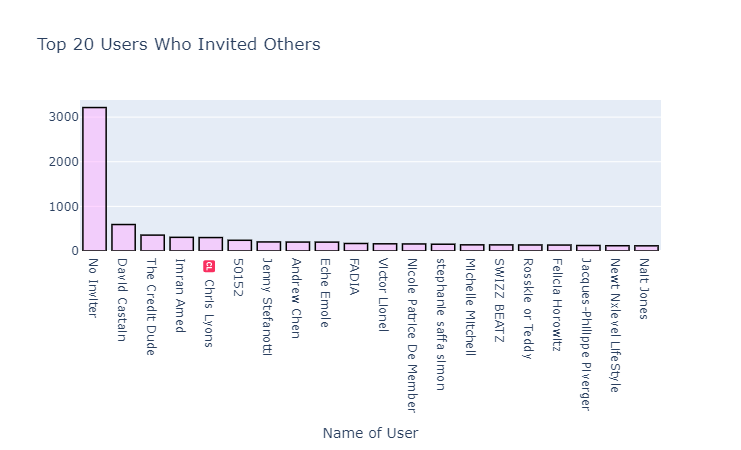

In [4]:
invited_by_df = users_df['invited_by_user_profile'].value_counts().to_frame()
invited_by_df.reset_index(level=0,inplace=True)
invited_by_df.columns = ['user_id','no_of_users_invited']
invited_by_df = invited_by_df.head(20)
invited_by_df['name'] = ['']*20
for i in range(invited_by_df.shape[0]):
    user_name = users_df.loc[users_df['user_id']==invited_by_df['user_id'].iloc[i]]['name'].values
    if len(user_name) !=0:
        invited_by_df.loc[i,'name'] = user_name[0]
    else:
        if invited_by_df['user_id'].iloc[i] == '':
            invited_by_df.loc[i,'name'] = 'No Inviter'
        else:
            invited_by_df.loc[i,'name'] = invited_by_df['user_id'].iloc[i]
            
trace1 = go.Bar(
                x = invited_by_df.name,
                y = invited_by_df.no_of_users_invited,
                name = "citations",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
data = [trace1]
layout = dict(title = 'Top 20 Users Who Invited Others',
              xaxis= dict(title= 'Name of User',ticklen= 5,zeroline= False)
             )
fig = go.Figure(data = data, layout = layout)
iplot(fig)

People with no inviter is the highest with 3214 users joined without an inviter. **David Castain** invited most (**593**) number of users.

Lets see the distribution of users based on followers

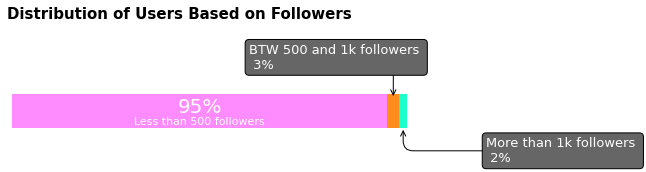

In [5]:
followers_following_df = users_df[['num_followers','num_following']]
users_less_05k_followers = followers_following_df.loc[(followers_following_df['num_followers']<500)].sort_values(['num_followers'],ascending=False)
users_05k_1k_followers = followers_following_df.loc[(followers_following_df['num_followers']>500) & (followers_following_df['num_followers']<1000)].sort_values(['num_followers'],ascending=False)
users_more1k_followers = followers_following_df.loc[(followers_following_df['num_followers']>1000)].sort_values(['num_followers'],ascending=False)

cluster_percents = pd.DataFrame(columns=['cluster_1','cluster_2','cluster_3'])
cluster_percents.loc[0,'cluster_1'] = round((users_less_05k_followers.shape[0]/users_df.shape[0])*100)
cluster_percents.loc[0,'cluster_2'] = round((users_05k_1k_followers.shape[0]/users_df.shape[0])*100)
cluster_percents.loc[0,'cluster_3'] = round((users_more1k_followers.shape[0]/users_df.shape[0])*100)

bbox = dict(boxstyle ="round", fc ="0.4")
arrowprops = dict(
    arrowstyle = "->",
    connectionstyle = "angle, angleA = 0, angleB = 90,rad = 10")
  
fig, ax = plt.subplots(1,1,figsize=(10, 2.5))

ax.barh(cluster_percents.index, cluster_percents['cluster_1'], 
        color='#FF80FF', alpha=0.9)
ax.barh(cluster_percents.index, cluster_percents['cluster_2'], left=cluster_percents['cluster_1'], 
        color='#FF8002', alpha=0.9)
ax.barh(cluster_percents.index, cluster_percents['cluster_3'], left=cluster_percents['cluster_1']+cluster_percents['cluster_2'],
        color='#00FFC8', alpha=0.9)


ax.set_xlim(-1.2, 140)
ax.set_ylim(-1.2, 2)
ax.set_xticks([])
ax.set_yticks([])


for i in cluster_percents.index:
    ax.annotate(f"{cluster_percents['cluster_1'][i]}%", 
                   xy=(cluster_percents['cluster_1']/2, i+0.1),
                   va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='san-serif',
                   color='white')

    ax.annotate("Less than 500 followers", 
                   xy=(cluster_percents['cluster_1'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=11, fontweight='light', fontfamily='san-serif',
                   color='white')
    
    
for i in cluster_percents.index:
  
    ax.annotate(f"BTW 500 and 1k followers \n {int(cluster_percents['cluster_2'][i])}%",
                   xy=(cluster_percents['cluster_1'][i]+cluster_percents['cluster_2'][i]/2, 0.3),
                   fontsize=13, fontweight='light', fontfamily='san-serif',
                   color='white',bbox = bbox, arrowprops = arrowprops,xytext =(60,1))

for i in cluster_percents.index:
    
    ax.annotate(f"More than 1k followers \n {int(cluster_percents['cluster_3'][i])}%", 
                   xy=(cluster_percents['cluster_1'][i]+cluster_percents['cluster_2'][i]+cluster_percents['cluster_3'][i]/2, -0.4),
                   fontsize=13, fontweight='light', fontfamily='san-serif',
                   color='white',bbox = bbox, arrowprops = arrowprops,xytext =(120, -1.2))



fig.text(0.125,0.92,'Distribution of Users Based on Followers', fontfamily='san-serif',fontsize=15, fontweight='bold')  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    

ax.legend().set_visible(False)
plt.show()


Majority of the data **(95%)** has users with followers **less than 500**. Where as users with **500-1k followers** constitute **3%** and more than **1k followers** is **2%**.

My analysis in this notebook is only in that **2% users**. Now lets look into this cluster and see the distribution.

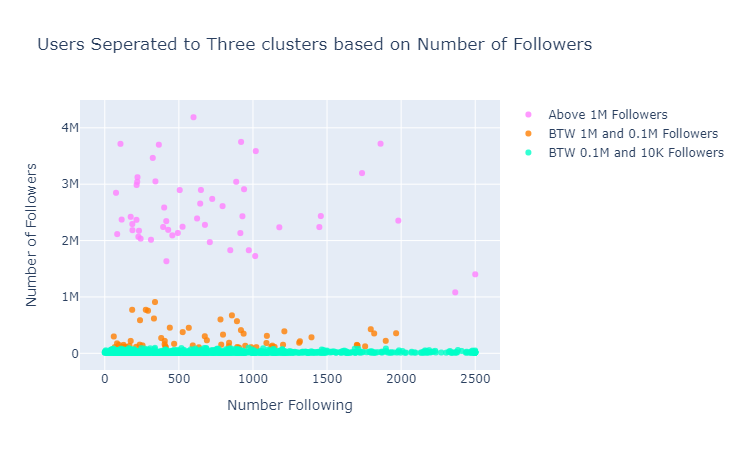

In [6]:
users_1m_followers = followers_following_df.loc[(followers_following_df['num_followers']>1000000)].sort_values(['num_followers'],ascending=False)
users_1m_followers['name'] = users_df['name'].iloc[users_1m_followers.index]
users_1m_followers.reset_index(level=0,inplace=True)

users_1m_less_followers = followers_following_df.loc[(followers_following_df['num_followers']>100000) & (followers_following_df['num_followers']<1000000)].sort_values(['num_followers'],ascending=False)
users_1m_less_followers['name'] = users_df['name'].iloc[users_1m_less_followers.index]
users_1m_less_followers.reset_index(level=0,inplace=True)
users_1m_less_followers

users_less_lm_followers = followers_following_df.loc[(followers_following_df['num_followers']>10000) & (followers_following_df['num_followers']<100000)].sort_values(['num_followers'],ascending=False)
users_less_lm_followers['name'] = users_df['name'].iloc[users_less_lm_followers.index]
users_less_lm_followers.reset_index(level=0,inplace=True)

trace1 =go.Scatter(
                    x = users_1m_followers.num_following,
                    y = users_1m_followers.num_followers,
                    mode = "markers",
                    name = "Above 1M Followers",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text= users_1m_followers.name)

trace2 =go.Scatter(
                    x = users_1m_less_followers.num_following,
                    y = users_1m_less_followers.num_followers,
                    mode = "markers",
                    name = "BTW 1M and 0.1M Followers",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text= users_1m_less_followers.name)

trace3 =go.Scatter(
                    x = users_less_lm_followers.num_following,
                    y = users_less_lm_followers.num_followers,
                    mode = "markers",
                    name = "BTW 0.1M and 10K Followers",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text= users_less_lm_followers.name)

data = [trace1,trace2,trace3]
layout = dict(title = 'Users Seperated to Three clusters based on Number of Followers',
              xaxis= dict(title= 'Number Following',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Number of Followers',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

Above plot show distribution of each cluster againt the number of users they are following. **James Andrews (1.4M Followers, 2500 Following)** has Highest number of follwers and also following more users.

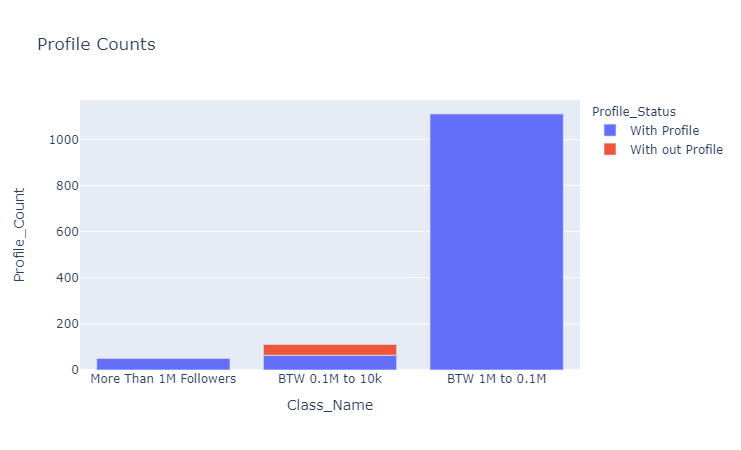

In [7]:
photo_url_dict = {'Class_Name':['More Than 1M Followers','BTW 1M to 0.1M','BTW 0.1M to 10k']*2,
                  'Profile_Status':['With Profile','With out Profile']*3,
                  'Profile_Count':[users_df.loc[users_1m_followers.index]['photo_url'].nunique(),users_df.loc[users_1m_followers.index]['photo_url'].isnull().sum(),
                                  users_df.loc[users_1m_less_followers.index]['photo_url'].nunique(),users_df.loc[users_1m_less_followers.index]['photo_url'].isnull().sum(),
                                  users_df.loc[users_less_lm_followers.index]['photo_url'].nunique(),users_df.loc[users_less_lm_followers.index]['photo_url'].isnull().sum()]
}
photo_url_df = pd.DataFrame.from_dict(photo_url_dict)

fig = px.bar(photo_url_df, x="Class_Name", y="Profile_Count", color="Profile_Status", title="Profile Counts")
fig.show()

Users in the clusters with more than 100k appears to have a profile picture where as those in 100k to 10k cluster do not appear to have a profile pictuer. **This might suggest that cluster 1 and 2 users have complete profiles.**

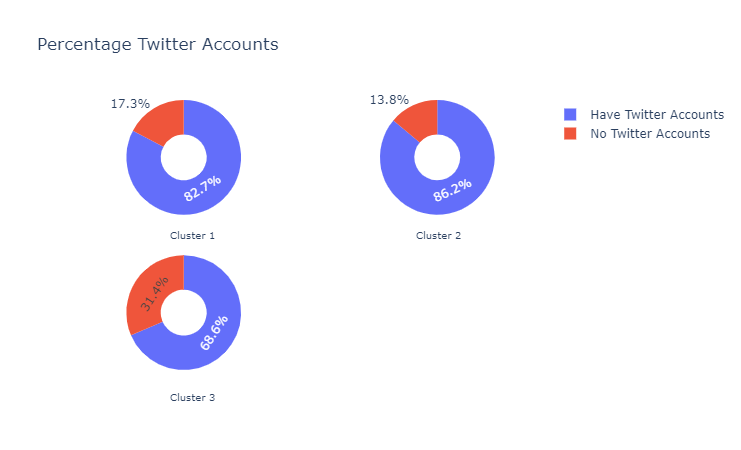

In [8]:
from plotly.subplots import make_subplots

import plotly.graph_objects as go


percent_class_1_with_twitter_accounts = ((users_df.loc[users_1m_followers.index]['twitter'].nunique()-1)/(users_df.loc[users_1m_followers.index]['twitter'].shape[0]))*100

class_1_dict = {'Account':['Have Twitter Accounts','No Twitter Accounts'],
              'Count':[percent_class_1_with_twitter_accounts,100-percent_class_1_with_twitter_accounts]
             }
class_1_df = pd.DataFrame.from_dict(class_1_dict)

##########

percent_class_2_with_twitter_accounts = ((users_df.loc[users_1m_less_followers.index]['twitter'].nunique()-1)/(users_df.loc[users_1m_less_followers.index]['twitter'].shape[0]))*100

class_2_dict = {'Account':['Have Twitter Accounts','No Twitter Accounts'],
              'Count':[percent_class_2_with_twitter_accounts,100-percent_class_2_with_twitter_accounts]
             }
class_2_df = pd.DataFrame.from_dict(class_2_dict)


###########

percent_class_3_with_twitter_accounts = ((users_df.loc[users_less_lm_followers.index]['twitter'].nunique()-1)/(users_df.loc[users_less_lm_followers.index]['twitter'].shape[0]))*100

class_3_dict = {'Account':['Have Twitter Accounts','No Twitter Accounts'],
              'Count':[percent_class_3_with_twitter_accounts,100-percent_class_3_with_twitter_accounts]
             }
class_3_df = pd.DataFrame.from_dict(class_3_dict)


fig = make_subplots(rows=2, cols=2,specs=[[{"type": "pie"},{"type": "pie"}],[{"type": "pie"},{"type": "pie"}]])
fig.add_trace(go.Pie(labels=class_1_df.Account, values=class_1_df.Count, name="Class-1"),
              1, 1)
fig.add_trace(go.Pie(labels=class_2_df.Account, values=class_2_df.Count, name="Class-2"),
              1, 2)
fig.add_trace(go.Pie(labels=class_3_df.Account, values=class_3_df.Count, name="Class-3"),
              2, 1)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4)

fig.update_layout(
    title_text="Percentage Twitter Accounts",
    annotations=[dict(text='Cluster 1', x=0.19, y=0.5, font_size=10, showarrow=False),
                 dict(text='Cluster 2', x=0.83, y=0.5, font_size=10, showarrow=False),
                dict(text='Cluster 3', x=0.19, y=-0.13, font_size=10, showarrow=False)])
fig.show()

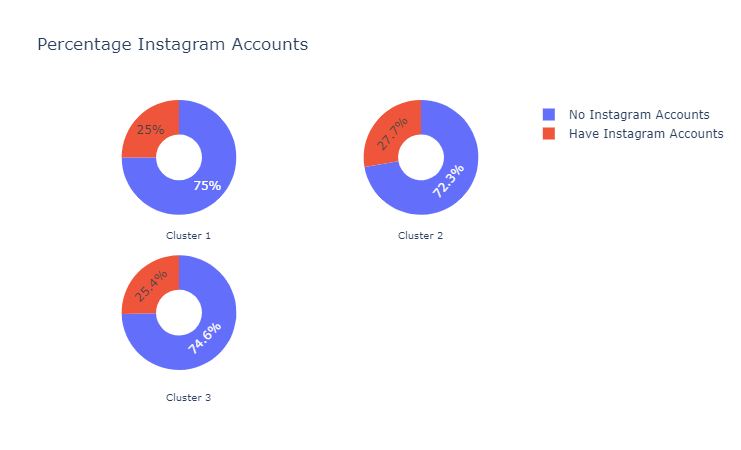

In [9]:
percent_class_1_with_instagram_accounts = ((users_df.loc[users_1m_followers.index]['instagram'].nunique()-1)/(users_df.loc[users_1m_followers.index]['instagram'].shape[0]))*100

class_1_dict = {'Account':['Have Instagram Accounts','No Instagram Accounts'],
              'Count':[percent_class_1_with_instagram_accounts,100-percent_class_1_with_instagram_accounts]
             }
class_1_df = pd.DataFrame.from_dict(class_1_dict)

##########

percent_class_2_with_instagram_accounts = ((users_df.loc[users_1m_less_followers.index]['instagram'].nunique()-1)/(users_df.loc[users_1m_less_followers.index]['instagram'].shape[0]))*100

class_2_dict = {'Account':['Have Instagram Accounts','No Instagram Accounts'],
              'Count':[percent_class_2_with_instagram_accounts,100-percent_class_2_with_instagram_accounts]
             }
class_2_df = pd.DataFrame.from_dict(class_2_dict)


###########

percent_class_3_with_instagram_accounts = ((users_df.loc[users_less_lm_followers.index]['instagram'].nunique()-1)/(users_df.loc[users_less_lm_followers.index]['instagram'].shape[0]))*100

class_3_dict = {'Account':['Have Instagram Accounts','No Instagram Accounts'],
              'Count':[percent_class_3_with_instagram_accounts,100-percent_class_3_with_instagram_accounts]
             }
class_3_df = pd.DataFrame.from_dict(class_3_dict)


fig = make_subplots(rows=2, cols=2,specs=[[{"type": "pie"},{"type": "pie"}],[{"type": "pie"},{"type": "pie"}]])
fig.add_trace(go.Pie(labels=class_1_df.Account, values=class_1_df.Count, name="Class-1"),
              1, 1)
fig.add_trace(go.Pie(labels=class_2_df.Account, values=class_2_df.Count, name="Class-2"),
              1, 2)
fig.add_trace(go.Pie(labels=class_3_df.Account, values=class_3_df.Count, name="Class-3"),
              2, 1)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4)

fig.update_layout(
    title_text="Percentage Instagram Accounts",
    annotations=[dict(text='Cluster 1', x=0.19, y=0.5, font_size=10, showarrow=False),
                 dict(text='Cluster 2', x=0.83, y=0.5, font_size=10, showarrow=False),
                dict(text='Cluster 3', x=0.19, y=-0.13, font_size=10, showarrow=False)])
fig.show()

Similar observation can be made about having twitter and instagram profiles. Users appear to have more twitter profiles linked than instagram. This is evident from first set of pie charts where cluster 1 and 2 users have more than **80% of twitter profiles** linked where as **instagram** links are around **75%**.

Another trend is between clusters where **highest follwers clusters have twitter and instagram accounts linked** where as lower cluster do not.

> **Network Diagrams**

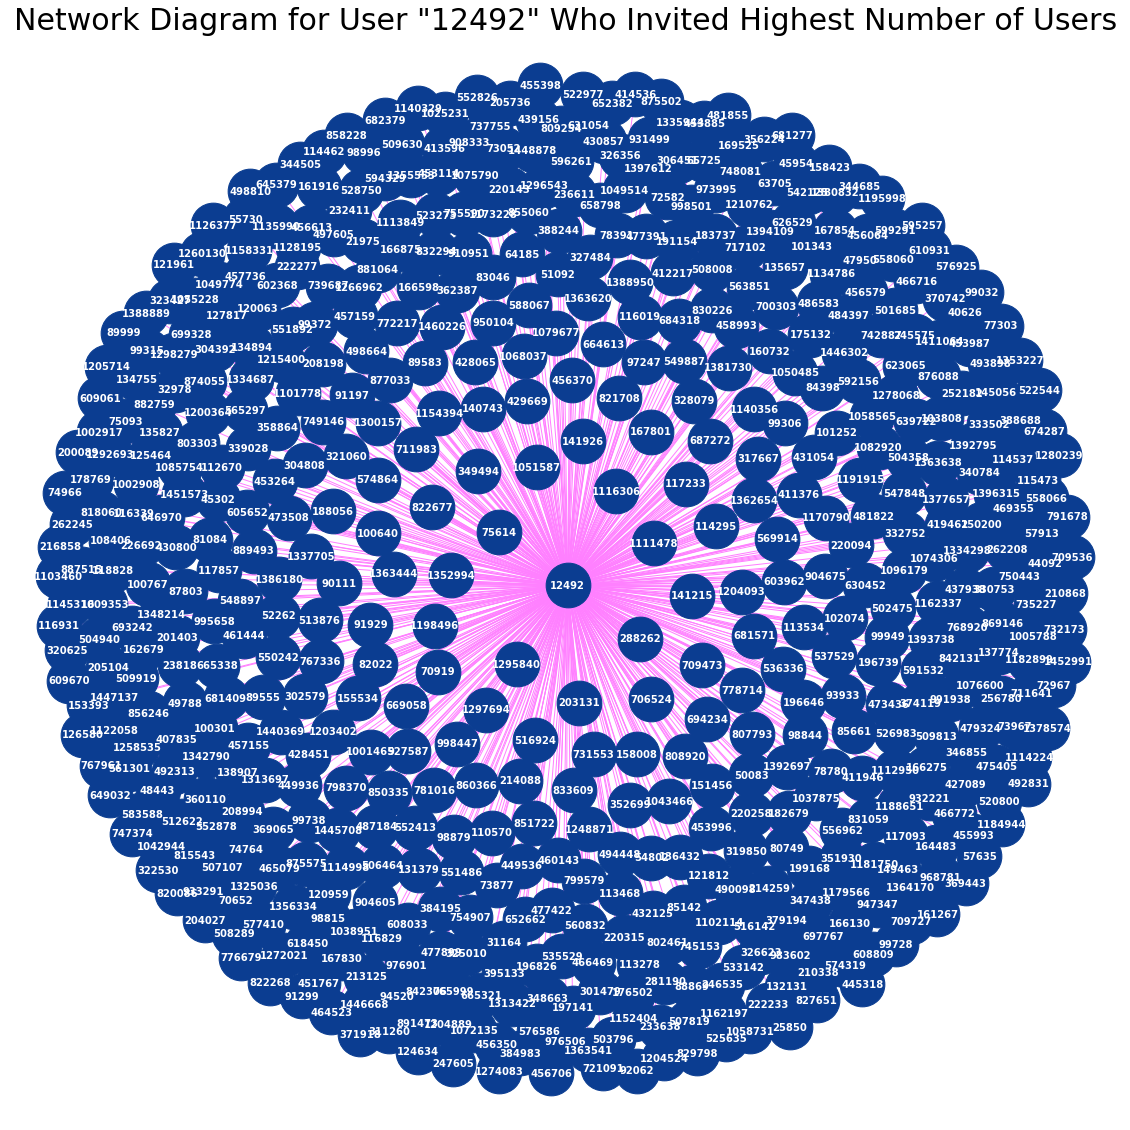

In [10]:
network_df_for_12492 = users_df[(users_df.invited_by_user_profile == 12492)]
G = nx.from_pandas_edgelist(network_df_for_12492, source='invited_by_user_profile', target='user_id', edge_attr=True,)
plt.rcParams['figure.figsize']  = (20, 20)
plt.title('Network Diagram for User "12492" Who Invited Highest Number of Users', fontsize = 30)

layout = nx.spring_layout(G)
nx.draw_networkx_nodes(G, layout, node_size = 2000, node_color = '#0B3D91')
nx.draw_networkx_edges(G, layout, width = 1, alpha = 1, edge_color = '#FF80FF')
nx.draw_networkx_labels(G, layout, font_size = 10, font_color='white', font_weight='bold')

plt.grid()
plt.axis('off')
plt.show()

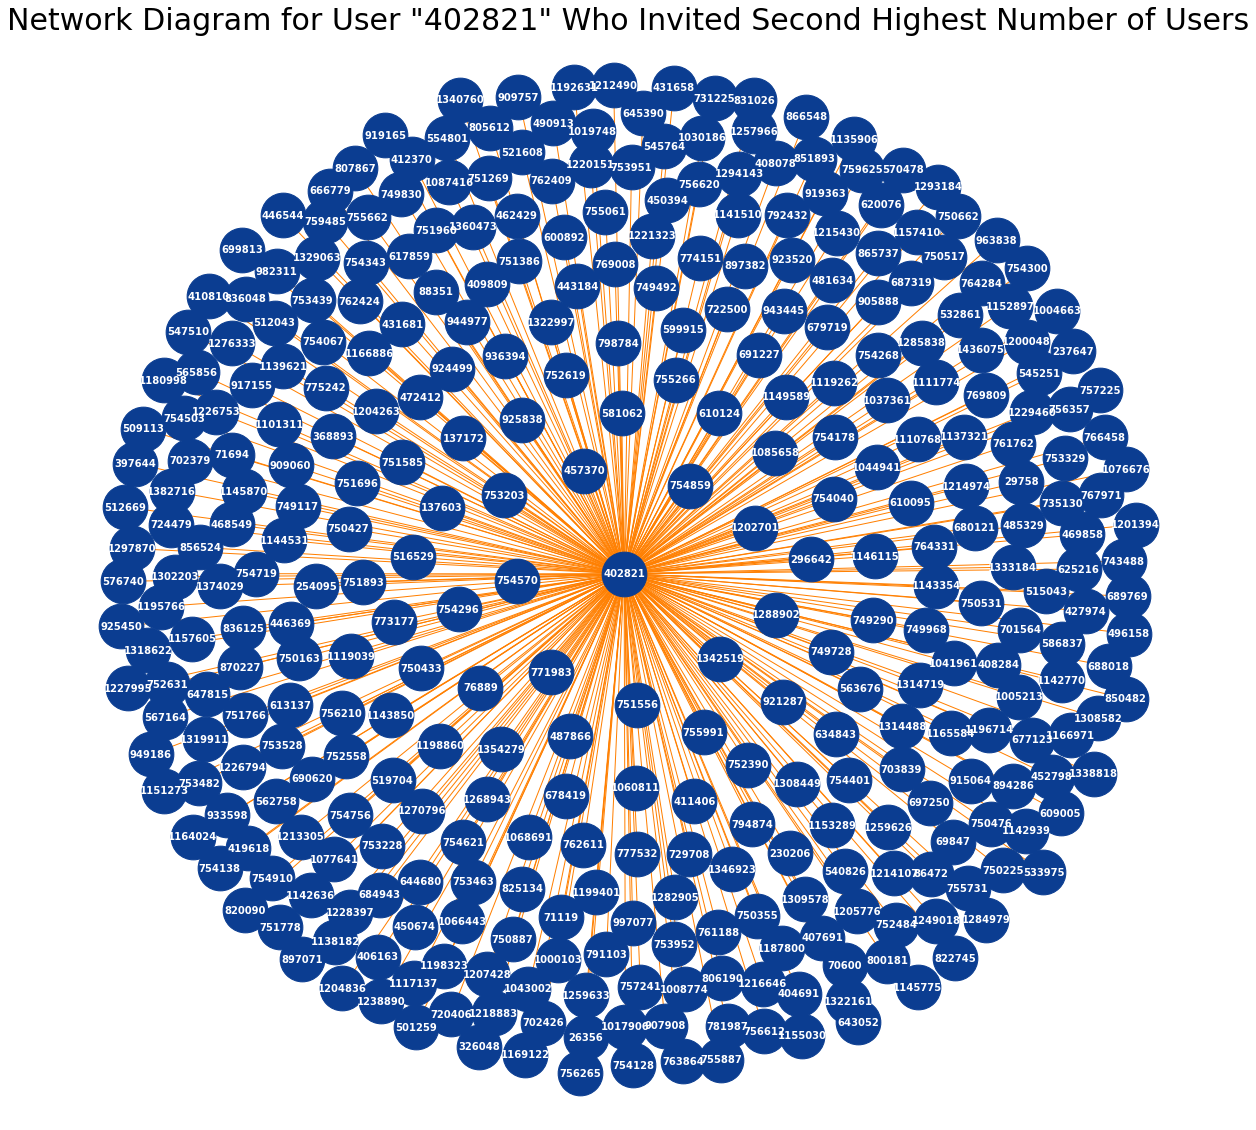

In [11]:
network_df_for_402821 = users_df[(users_df.invited_by_user_profile == 402821)]
G = nx.from_pandas_edgelist(network_df_for_402821, source='invited_by_user_profile', target='user_id', edge_attr=True,)
plt.rcParams['figure.figsize']  = (20, 20)
# plt.style.use('dark_background')
plt.title('Network Diagram for User "402821" Who Invited Second Highest Number of Users', fontsize = 30)

layout = nx.spring_layout(G)
nx.draw_networkx_nodes(G, layout, node_size = 2000, node_color = '#0B3D91')
nx.draw_networkx_edges(G, layout, width = 1, alpha = 1, edge_color = '#FF8002')
nx.draw_networkx_labels(G, layout, font_size = 10, font_color='white', font_weight='bold')

plt.grid()
plt.axis('off')
plt.show()

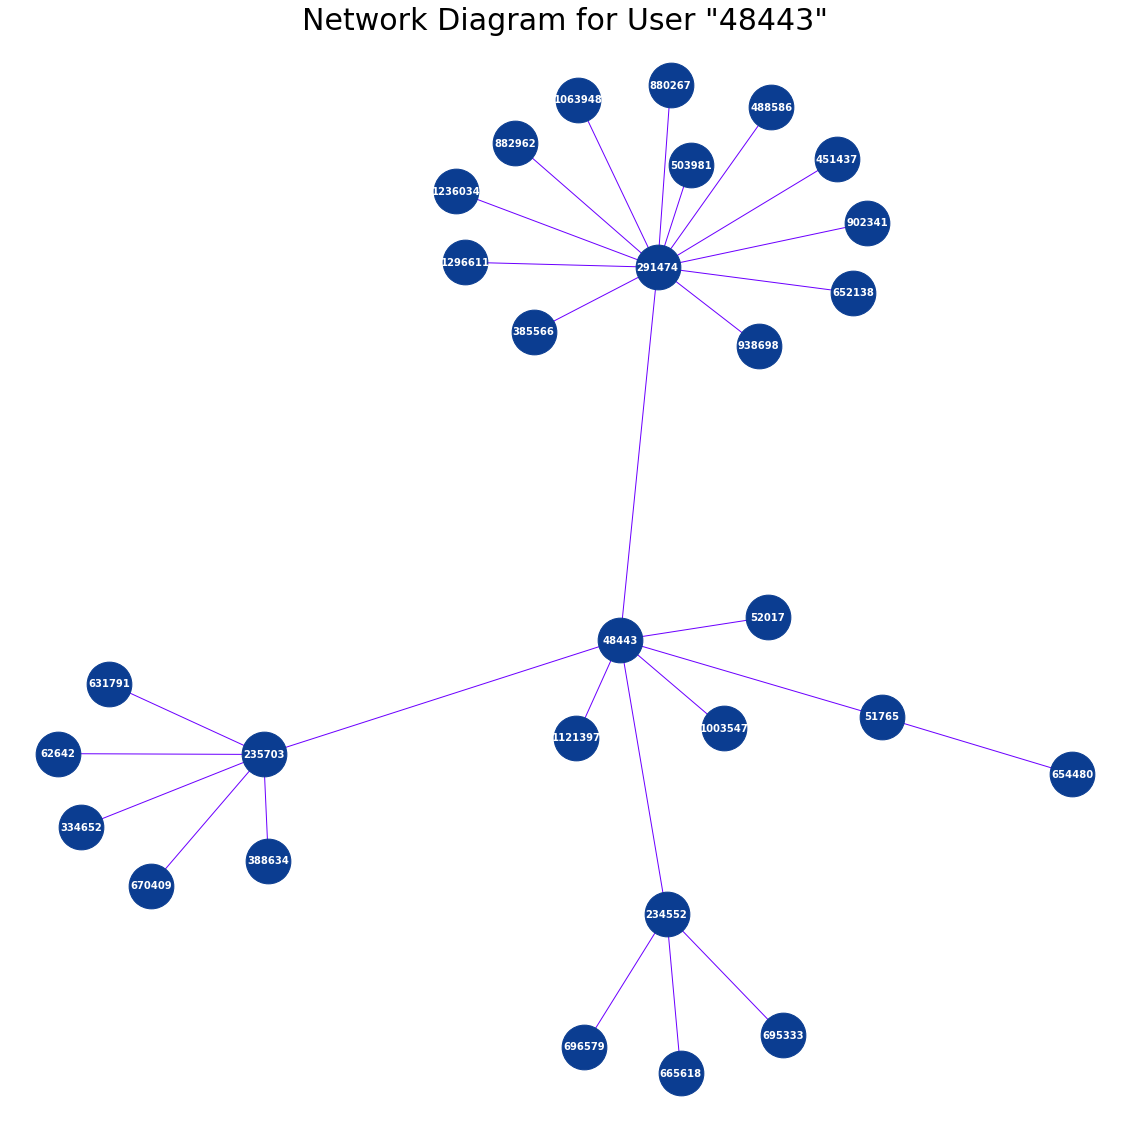

In [12]:
network_df_for_48443 = users_df[(users_df.invited_by_user_profile == 48443)]
network_df_for_48443 = network_df_for_48443.reset_index()
for i in range(network_df_for_48443.shape[0]):
    network_df_for_48443 = network_df_for_48443.append(users_df[(users_df.invited_by_user_profile == network_df_for_48443['user_id'].iloc[i])])
G = nx.from_pandas_edgelist(network_df_for_48443, source='invited_by_user_profile', target='user_id', edge_attr=True,)
plt.rcParams['figure.figsize']  = (20, 20)
# plt.style.use('dark_background')
plt.title('Network Diagram for User "48443"', fontsize = 30)

layout = nx.spring_layout(G)
nx.draw_networkx_nodes(G, layout, node_size = 2000, node_color = '#0B3D91')
nx.draw_networkx_edges(G, layout, width = 1, alpha = 1, edge_color = '#6D01FF')
nx.draw_networkx_labels(G, layout, font_size = 10, font_color='white', font_weight='bold')

plt.grid()
plt.axis('off')
plt.show()

These plots are only a fraction of the whole network. Similar plot can be made for the entire data.

<center><h2><b>Thanks for reading. Please give your suggestions and comments.</b></h2></center>